Lau Jun Kit Darrick, dl5215, 01112514

# 1. Regression Methods
## 1.1 Processing Stock Price Data in Python
### 1.1.1 Time-series Plot

Let's start with a basic sanity check by visualising the types of the dataset.

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
%matplotlib inline

data = pd.read_csv("data/priceData.csv")
print(data.dtypes)
data.isnull().sum()

date          object
SPX Index    float64
dtype: object


date           0
SPX Index    655
dtype: int64

We see that there are actually 655 null values present in the `SPX Index` column, where we expect a `float64`. Additionally, the `Date` column is not required, so let's get rid of it. The data is not perfectly sequential, so we'll get rid of the entries with `dropna()`.

<AxesSubplot:title={'center':'Logarithmic SPX Price'}>

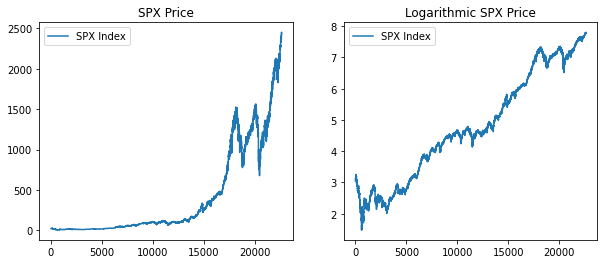

In [6]:
px = data.drop(['date'], axis=1)
px = px.dropna()
logpx = np.log(px)

figure, axes = plt.subplots(1,2)
figure.set_size_inches(10,4)

px.plot(title="SPX Price", ax=axes[0])
logpx.plot(title="Logarithmic SPX Price", ax=axes[1])

We see immediately that there is an upward trend in both graphs, and that applying the natural logarithm suppresses the range of the output, while still preserving order. To draw further observations on the stationarity (or lack thereof) of this time series, let's plot some additional statistics. 

### 1.1.2 Sliding Mean & Variance

A stationary process is a stochastic process whose probability distribution does not change with time. Simply put, this means that measures such as mean and variance should be constant throughout the process. Real data, which we handle throughout this report, is very rarely perfectly in line with this definition, however, and so henceforth we use the term "stationary" loosely to refer to a time-series which has a stable, albeit slightly oscillating mean and tolerable variance.

**(Nothing in the lectures discusses this. What thresholds for mean and variance oscillation do we tolerate before we consider data unsuitable for signal processing? Are there any quantatitive methods to determine confidence in an underlying data set?)

Taking a sliding window of 252 samples, it can be observed that there is an upward trend in the mean with no easily discernable seasonal pattern. Spikes in variance correspond to corrections or market crashes, where large relative daily changes in price are observed. While the standard deviation is relatively stable, oscillating within 0.3, the upward movement in the mean breaks our definition of stationarity, and will require additional mathematical manupulation to remove, which we will explore in upcoming sections.

<AxesSubplot:title={'center':'252-day Sliding Standard Deviation'}>

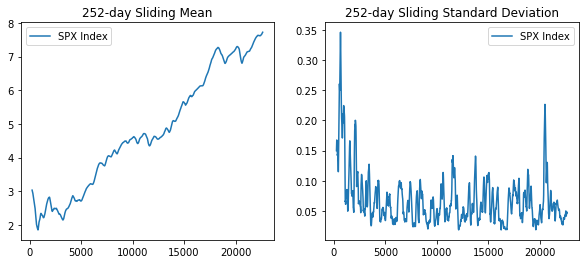

In [7]:
figure, axes = plt.subplots(nrows=1, ncols=2)

# Sliding Mean & S.D.
figure.set_size_inches(10,4)
logpx.rolling(252).mean().plot(ax=axes[0], title="252-day Sliding Mean")
logpx.rolling(252).std().plot(ax=axes[1], title="252-day Sliding Standard Deviation")

### 1.1.3 Simple & Log-return Time Series

Comparing the two plots, we see the property of the natural logarithm where $ Log(1+r) \approx x $ for small $r$. In fact, the two graphs are almost indistinguishable as daily percentage changes in the S&P500 are usually within this approximation tolerance, except for a few outlying points. 

First-order differencing has successfully de-trended the moving average, and the standard deviation has been reduced by a factor of 10. This time-series is much more stationary as the mean oscillates in very small amplitudes around 0, implying a mean-reverting nature of this time-series. Furthermore, the data in both cases exhibit gaussian properties which further motivate the application of signal processing techniques.

<AxesSubplot:title={'center':'252-day Sliding Window S.D. of Simple returns'}>

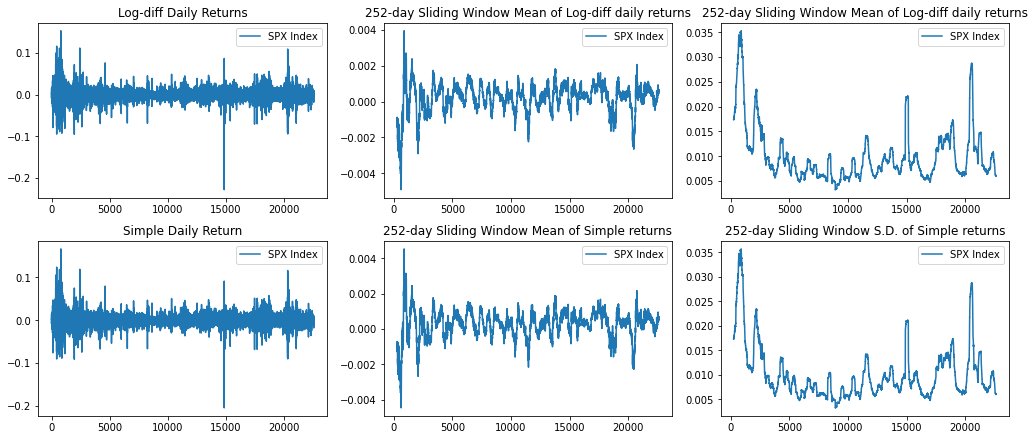

In [8]:
figure.clf()
figure, axes = plt.subplots(nrows=2, ncols=3, constrained_layout=True)
figure.set_size_inches(14,6)

logret = logpx.diff()
logret.plot(title="Log-diff Daily Returns", ax=axes[0,0])
logret.rolling(252).mean().plot(title="252-day Sliding Window Mean of Log-diff daily returns", ax=axes[0,1])
logret.rolling(252).std().plot(title="252-day Sliding Window Mean of Log-diff daily returns", ax=axes[0,2])

simpret = px.pct_change()
simpret.plot(title="Simple Daily Return", ax=axes[1,0])
simpret.rolling(252).mean().plot(title="252-day Sliding Window Mean of Simple returns", ax=axes[1,1])
simpret.rolling(252).std().plot(title="252-day Sliding Window S.D. of Simple returns", ax=axes[1,2])

### 1.1.4 Theoretically justify the suitability of log returns over simple returns for signal processing purposes. Next, perform the “Jarque-Bera” test for Gaussianity on the data, and comment on the results in light of your theoretical answer.



A common assumption in quantitative finance is that prices are log-normally distributed in the short term. Therefore, taking the log of the prices results in normally distributed log-prices.

Signal processing techniques often assume that the samples of the underlying stochastic process is normally distributed, and so we see a good fit when the two contexts are combined.

"Gaussianity", as it is so-called, can be formally tested with the "Jarque-Bera" test which provides a scalar measure of how the skewness and kurtosis of a distribution matches that of a normal distribution, which has skewness $S=0$ and kurtosis $C=3$. 

$$
JB = \frac{n}{6}(S^2 + \frac{(C-3)^2}{4})
$$

From the definition above, we see that a JB-test value of 0 indicates that the tested data perfectly emulates a normal distribution, and the test value increases as the underlying data deviates further from gaussianity.

,Log-diff JB,Log p-value,Simple returns JB,Simple returns p-values
Months,,,,
1,1.050136,5.915151e-01,1.043967,5.933425e-01
2,0.955807,6.200821e-01,0.914655,6.329732e-01
3,1.876383,3.913350e-01,1.810365,4.044681e-01
4,12.476409,1.953360e-03,11.268285,3.573740e-03
5,8.829944,1.209490e-02,7.989605,1.841109e-02
6,192.740162,0.000000e+00,158.937263,0.000000e+00
7,147.718908,0.000000e+00,120.286232,0.000000e+00
8,148.533099,0.000000e+00,120.821902,0.000000e+00
9,111.436987,0.000000e+00,89.782614,0.000000e+00


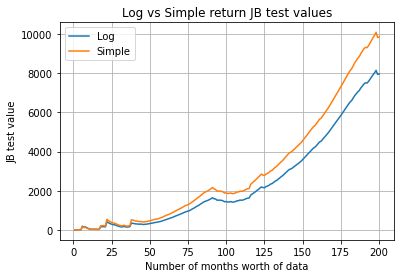

In [9]:
from scipy import stats

steps = [i for i in range (21, len(logret.dropna()), 21)]
months = list(map(lambda x: int(x/21),steps))
logdiff_jb_vals = [stats.jarque_bera(logret.dropna()[:step]) for step in steps]
simpret_jb_vals = [stats.jarque_bera(simpret.dropna()[:step]) for step in steps]
logdiff_jbs, logdiff_pvals = map(list, zip(*logdiff_jb_vals))
simpret_jbs, simpret_pvals = map(list, zip(*simpret_jb_vals))

plotted_points = 200
plt.clf()
plt.title("Log vs Simple return JB test values")
plt.ylabel("JB test value")
plt.xlabel("Number of months worth of data")
plt.grid()
plt.plot(months[:plotted_points], logdiff_jbs[:plotted_points], label="Log")
plt.plot(months[:plotted_points], simpret_jbs[:plotted_points], label="Simple")
plt.legend()

results = pd.DataFrame(data={"Months": months, "Log-diff JB": logdiff_jbs, "Log p-value": logdiff_pvals, "Simple returns JB": simpret_jbs, "Simple returns p-values": simpret_pvals})
results = results.set_index("Months")
results.head(10)

Jarque-bera test values are computed and plotted for a range of sample data sizes, starting at 21 and increasing by 21 at each step. This approximates an increase of a month's data at each step, since there are approximately 21 trading days in a month. The JB values are consistently trending upward into very large values with the inclusion of more months' data. Simple returns also yield higher JB-test values compared to log-prices, as we would expect. 

We see that even for a single month of data, we approach JB-test values close to or above 1, implying that this "short-term" in which prices may be assumed to be log-normally distributed may be a matter of weeks, and may require data of increased granularity than daily closing prices.

The p-value is the probability of obtaining the observed results given the null hypothesis. Therefore, in this case, our p-values being close to zero for almost every sample size indicates that we have a very strong case against the null hypothesis that these SPX closing prices are normally distributed.

### 1.1.5 You purchase a stock for £1. The next day its value goes up to £2 and the following day back to £1. What are the simple and logarithmic returns over this period and what can you conclude about logarithmic returns on the basis of this example?

We see from the simple script that the price movement that the movement of the log-price matches that of the original price. An increase of $1 (100%) followed by a decrease of the same amount (50%) results in 2 equal and opposite movements of 0.693 in the logarithm. However, the percentage price is different in both cases. Logarithmic returns thus allow us to track and analyse a series of gains and losses in a more symmetric and predictable way than simple returns.

In [10]:
simple_stock_price = pd.DataFrame(data=[1,2,1], columns=["Price"])
simple_stock_price['Simple Return'] = simple_stock_price.pct_change()
simple_stock_price['Log-price Diff'] = np.log(simple_stock_price['Price']).diff()
simple_stock_price

,Price,Simple Return,Log-price Diff
0,1,NaN,NaN
1,2,1.0,0.693147
2,1,-0.5,-0.693147


### 1.1.6 Under what circumstances should you not use log returns over simple returns?

Most models in quantitative finance argue that prices in the short-term are log-normally distributed. Taking log-returns for long-term analysis breaches this assumption and the resulting time series may not be ideal. 

Let us consider the problem of portfolio optimisation using the Markowitz model. We aim to find an optimal weighting vector $w$ across assets to maximise returns while minimising risk (variance). 

Using simple returns, we can easily determine the simple return in our portfolio over time given by the vectorial equation $r_p = w^Tr$. Because of this, we say that simple returns are additive across assets, as we can take the simple returns across all our assets (the vector $r$), scale them by our allocation weights $w$ and determine a simple return for our whole portfolio.

Log-returns cannot be used for this purpose since the weighted average of the log returns across assets does not equal the return of the portfolio.

## 1.2 ARMA vs. ARIMA Models for Financial Applications

### 1.2.1 Plot the S&P500 time-series. Following the process in Question 1.1.1, comment on whether an ARMA or ARIMA model would be more appropriate.

Let's do our usual sanity check of visualising the data and checking for nulls.


In [11]:
import pandas as pd
import matplotlib . pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR 
import copy

snp = pd.read_csv("data/snp_500_2015_2019.csv", index_col=0)

print(snp.isna().sum())
snp.head(5)


High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,2072.360107,2046.040039,2058.899902,2058.199951,2708700000,2058.199951
2015-01-05,2054.439941,2017.339966,2054.439941,2020.579956,3799120000,2020.579956
2015-01-06,2030.250000,1992.439941,2022.150024,2002.609985,4460110000,2002.609985
2015-01-07,2029.609985,2005.550049,2005.550049,2025.900024,3805480000,2025.900024
2015-01-08,2064.080078,2030.609985,2030.609985,2062.139893,3934010000,2062.139893


<AxesSubplot:title={'center':'252-day rolling s.d.'}, xlabel='Date'>

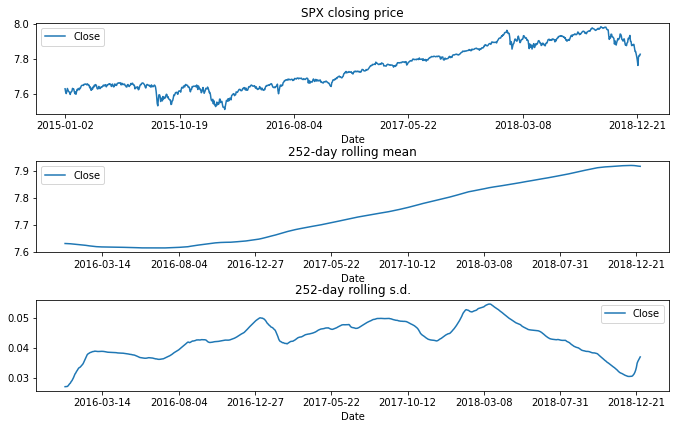

In [19]:
snp_close = snp["Close"].to_frame().apply(np.log)

figure, axes = plt.subplots(nrows=3, ncols=1)
figure.tight_layout()
figure.set_size_inches(10,6)

axes[0].set_title("SPX closing price")
snp_close.plot(ax=axes[0])
axes[1].set_title("252-day rolling mean")
snp_close.rolling(252).mean().plot(ax=axes[1])
axes[2].set_title("252-day rolling s.d.")
snp_close.rolling(252).std().plot(ax=axes[2])

We see from the data that this time series is clearly not stationary due to the upward trend that we observed in the previous section, and so an ARIMA method would be more appropriate so that we may skip the hassle of finding an appropriate de-trending solution. We will see that an ARMA model will not be ideal since we are applying it to non-stationary data, which is otherwise a requirement of ARMA models.

### 1.2.2 Fit an ARMA(1, 0) model using the commands below. Plot, in the same figure, both the prediction and the true signal. Inspect the model parameters (model.params). Comment on the results. Are these findings useful in practice?

The model initially looks to be fitting the data very well, but closer inspection shows that the predicted version lags the true signal. We have fit an AR(1) model, whose moving-average component is simple white noise. Therefore, we observe that when large changes occur in the data, a corresponding spike is observed in the residual. Interestingly, the residual itself looks like stationary white noise.

We know as fact that "shocks" occur in the market due to the random availability of new information to investors, and clearly is not correctly modelled by white noise in this case.

**(The question asks us to investigate the model parameters, but these were not explained in the lectures or slides. I've tried to look into statsmodels documentation and wikipedia to make sense of it, but to no avail. Any advice?)

/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,const,ar.L1,sigma2,JB
0,7.748867,0.997354,0.000074,33142.752272


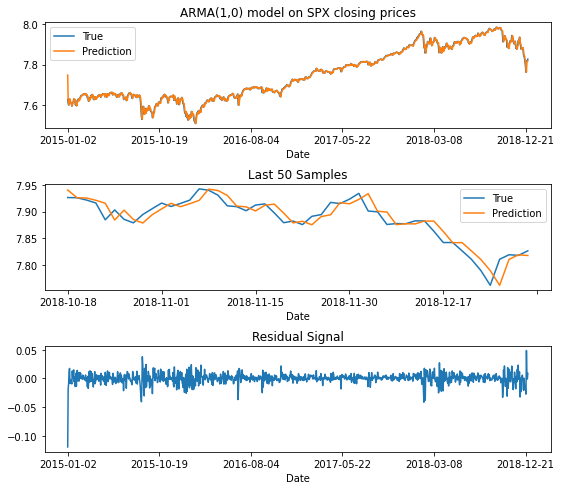

In [20]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ["True"]
model = ARIMA(snp_arma, order=(1,0,0)).fit()
snp_arma["Res"] = model.resid
snp_arma["Prediction"] = snp_arma["True"] - snp_arma["Res"]

figure, axes = plt.subplots(nrows=3, ncols=1)
figure.tight_layout()
figure.set_size_inches(8,7)

axes[0].set_title("ARMA(1,0) model on SPX closing prices")
snp_arma.drop(["Res"], axis=1).plot(ax=axes[0])

axes[1].set_title("Last 50 Samples")
snp_arma.drop(["Res"], axis=1).iloc[-50:].plot(ax=axes[1])

axes[2].set_title("Residual Signal")
snp_arma["Res"].plot(ax=axes[2])

residual_jb_vals = stats.jarque_bera(snp_arma["Res"])

results = model.params.to_frame().transpose()
results["JB"] = residual_jb_vals[0]
results

### 1.2.3 Repeat Question 1.2.2, this time by fitting an ARIMA(1, 1, 0) model. Comment on the results. Compare your results with those in Question 1.2.2. Which analysis is more physically meaningful?

The differencing step by this model removes non-stationary components in the mean of the time-series, as we saw in previous sections. This has removed the initial spike in the residual that we saw previously. We therefore expect the AR model fitted afterwards to perform better than the one in question 1.2.2. 

However, we still observe the same issue as in the last model, where price "shocks" are not modelled by a moving-average component.

/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,ar.L1,sigma2,JB
0,-0.00817,0.000074,684.989129


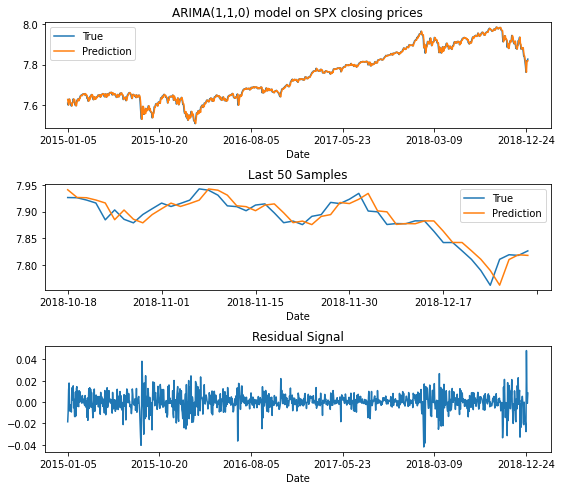

In [22]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ["True"]
model = ARIMA(snp_arima, order=(1,1,0)).fit()
snp_arima["Res"] = model.resid
snp_arima["Prediction"] = snp_arima["True"] - snp_arima["Res"]

figure, axes = plt.subplots(nrows=3, ncols=1)
figure.tight_layout()
figure.set_size_inches(8,7)

axes[0].set_title("ARIMA(1,1,0) model on SPX closing prices")
snp_arima.drop(["Res"], axis=1)[1:].plot(ax=axes[0])

axes[1].set_title("Last 50 Samples")
snp_arima.drop(["Res"], axis=1).iloc[-50:].plot(ax=axes[1])

axes[2].set_title("Residual Signal")
snp_arima["Res"][1:].plot(ax=axes[2])

results = model.params.to_frame().transpose()
results["JB"] = stats.jarque_bera(snp_arima["Res"][1:])[0]
results

### 1.2.4 Comment on the necessity of taking the log of the prices for the ARIMA analysis.

As we explored in previous sections, taking the log-difference of two prices is approximate to obtaining the return for a small enough change. Therefore, taking the logarithm of the daily prices before applying an ARIMA model means we are fitting an AR model on the intra-day log-returns of the prices. Physically, this makes more sense as prices are less likely to be historically based, whereas returns might be.

Taking logarithms also increases stationarity my reducing the range of the variance, which we showed in previous sections.

/home/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<AxesSubplot:xlabel='Date'>

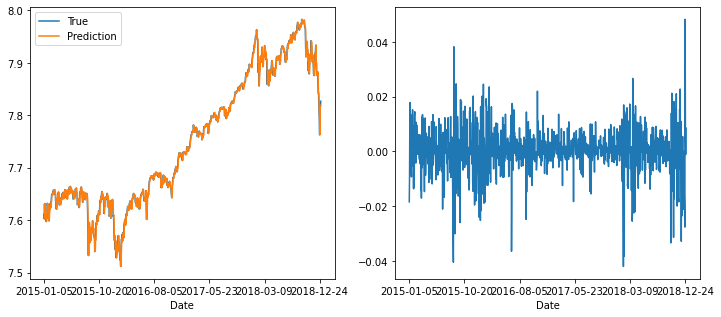

In [57]:
snp_close_log = snp["Close"].to_frame().apply(np.log)
snp_arima_log = copy.deepcopy(snp_close_log)
snp_arima_log.columns = ["True"]
model = ARIMA(snp_arima_log, order=(1,1,0)).fit()
snp_arima_log["Res"] = model.resid
snp_arima_log["Prediction"] = snp_arima_log["True"] - snp_arima_log["Res"]

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12,5)
snp_arima_log.drop(["Res"], axis=1)[1:].plot(ax=axes[0])
snp_arima_log["Res"][1:].plot(ax=axes[1])

## 1.3 Vector Autoregressive (VAR) Models

### 1.3.1 Show that a VAR model can be represented in a concise matrix form $Y = BZ + U$

An autoregressive (AR) process models future values based on the linear combination of past values in a single stochastic process. A vector autoregressive model, by extension, extends this notion by forecasting a future value based on past combinations of multiple processes. It can therefore be expressed in the general form

$$
y_t = c + A_1y_{t−1} + A_2y_{t−2} +···+ A_py_{t−p} + e_t
$$

To obtain a more concise form, we can collect the coefficients and process terms into separate matrices like so:

$$
\textbf{B} = 
    \begin{vmatrix}
        \textbf{c} & \textbf{A}_1 & \textbf{A}_2 & ... & \textbf{A}_p 
    \end{vmatrix}
$$

$$
\textbf{Z} = 
    \begin{vmatrix}
        \textbf{1} & \textbf{y}^T_{t-1} & \textbf{y}^T_{t-2} & ... & \textbf{y}^T_{t-p} 
    \end{vmatrix}
$$

Now, let $\textbf{Y} = \textbf{y_t}$ and $ \textbf{U} = \textbf{e_t}$, we obtain the equivalent matrix form 

$$
\textbf{Y = BZ + U}
$$


### 1.3.2 Hence, show that the optimal set of coefficients $B$, denoted by $B_{opt}$, is obtained via $B_{opt} = YZ^T(ZZ^T)^{-1} $

As in the autoregressive model, the matrix $\textbf{U}$ represents the errors (residual) in the model. Treating this as an optimisation problem, we want to find the solution for the equation $\textbf{Y = BZ + U}$ that minimises $\textbf{U}$. 

We solve this minimisation by finding a least-squares estimation for $\textbf{B}$ and minimising the objective
$$
    \textbf{U}^2 = \textbf{(BZ - Y)}^2          \\
    \textbf{U}^2 = \textbf{(BZ - Y)(BZ-Y)}^T

$$

### 1.3.4 Consider the time-series of the stocks with tickers CAG, MAR, LIN, HCP, MAT, and detrend them using an MA(66) model (66 corresponds to 3 × 22, i.e. one quarter). Elaborate on whether it would make sense to construct a portfolio using these stocks? Why? Comment on your results.

<AxesSubplot:title={'center':'De-trended Stocks Prices'}, xlabel='Date'>

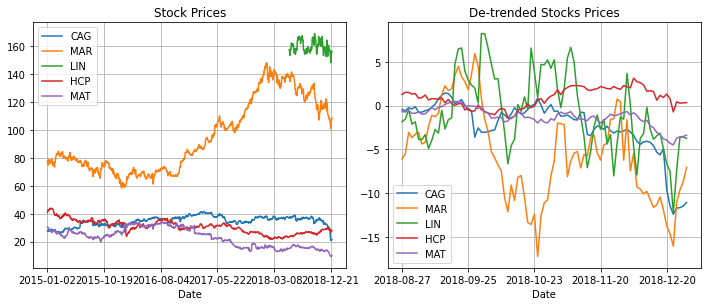

In [49]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from statsmodels.tsa.api import VAR

df = pd.read_csv('data/snp_allstocks_2015_2019.csv')
df = df.set_index('Date')

info = pd.read_csv('data/snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)

# Consider the time-series of the stocks with tickers CAG, MAR, LIN, HCP, MAT, and detrend them using an MA(66) model (66 corresponds to 3 × 22, i.e. one quarter), that is, run
tickers = ['CAG' , 'MAR' , 'LIN' , 'HCP' , 'MAT']
stocks = df[tickers]
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(10,4)
figure.tight_layout()
stocks.plot(grid=True, title='Stock Prices', ax=axes[0])
stocks_detrended.plot(grid=True, title='De-trended Stocks Prices', ax=axes[1])

In [50]:
# Now, fit a VAR(1) model to these time-series and compute the eigenvalues of the regression matrix A, by:
model = VAR(stocks_detrended)
results = model.fit(1)
results.params[1:].transpose()

/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,L1.CAG,L1.MAR,L1.LIN,L1.HCP,L1.MAT
CAG,0.872786,-0.063745,0.000134,-0.084776,0.643072
MAR,0.113179,0.895820,-0.111678,-0.083831,0.094931
LIN,-0.281265,-0.184820,0.704023,-0.401417,2.033036
HCP,0.011912,-0.005004,0.004982,0.931708,-0.012884
MAT,0.058776,0.022917,-0.025557,-0.046406,0.802974


Fitting the VAR(1) model and inspecting the model parameters tells an interesting story: The forecasted value of a given stock is mostly comprised of its previous value, with small inputs from other stocks. Intuitively, this tells us that the stocks are largely uncorrelated, with the exception of LIN and MAT, which could be due to LIN having very little data available compared to the other stocks. 

The parameters are physically quite related to covariances, since each coefficient represents "how much" of the lagged variable contributed to the present value. We also observe empirically that the diagonals contain the largest values, which we expect in a "covariance" matrix. 

In [45]:
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)
print("Eigenvalues:", eigA)
print("Average: ", np.mean(eigA))
print("Max: ", np.max(eigA))
print("Min: ", np.min(eigA))

Eigenvalues: [0.71449288+0.12927613j 0.71449288-0.12927613j 1.00635964+0.j
 0.86051894+0.j         0.91144512+0.j        ]
Average:  (0.8414618919995338+0j)
Max:  (1.006359640461021+0j)
Min:  (0.7144928806785362-0.1292761251261281j)


Performing eigenvector analysis on this "matrix" yields an interesting result: The largest eigenvalue is 1.006, which means the largest possible "variance" one can incur from a portfolio constructed from these stocks is 1.006 and the average eigenvalue is 0.841. The "covariance" matrix shows us that the stocks are largely uncorrelated, and so constructing a portfolio from these may be a sensible choice. However, these dimensionless values do not have much meaning on their own, so in the next section we will explore the same analyses across industry sectors.

### 1.3.5 With the aid of snp_info.csv, repeat Question 1.3.4 but this time by selecting the tickers according to their sector

In [61]:
mean_eigens = []
max_eigens = []
num_stonks = []

for sector in info['GICS Sector'].unique():
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = df[tickers]
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()

    model = VAR(stocks_detrended)
    results = model.fit(1)
    results.params[1:].transpose()
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)
    
    mean_eigens += [eigA.mean()]
    max_eigens += [eigA.max()]
    num_stonks += [len(tickers)]

results = pd.DataFrame(info['GICS Sector'].unique(), columns=["Sector"])
results['Max Eigenval'] = max_eigens
results['Mean Eigenval'] = mean_eigens
results['# of Stocks'] = num_stonks
results

/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/darrekt/.pyenv/versions/SPMLF/lib/python3.9/site-packages/statsmodels/ts

,Sector,Max Eigenval,Mean Eigenval,# of Stocks
0,Industrials,0.991568+0.017404j,0.750818+0.000000j,69
1,Health Care,0.993598+0.033204j,0.441843+0.000000j,62
2,Information Technology,0.992075+0.036269j,0.803445-0.000000j,68
3,Communication Services,0.982234+0.007508j,0.925770-0.000000j,26
4,Consumer Discretionary,0.989860+0.039565j,0.804006+0.000000j,65
5,Utilities,0.983506+0.064941j,0.463644+0.000000j,27
6,Financials,1.003000+0.051864j,0.418911-0.000000j,68
7,Materials,0.990101+0.057061j,0.481792-0.000000j,26
8,Real Estate,0.982744+0.009006j,0.918568+0.000000j,31
9,Consumer Staples,0.991324+0.019122j,0.849384+0.000000j,33


We now automate the eigenvalue analysis across the sectors. We started with a hypothesis that investing across a single sector should be worse than our original porfolio in the previous section, since stocks in the same sector should have a higher correlation. We see however that this is untrue, as the maximum eigenvalues are all lower than that of the previous stock spread. 

This could be due to a number of factors, as the S&P 500 contains many large-cap companies in each sector, each of which may have disjoint business concerns within the sector which may reduce correlation between company stock performance. Additionally, the number of stocks in each sector is much larger than the previous selection of only 5 stocks. The mean eigenvalue differs greatly across sectors. For example, healthcare and utilities have he lowest mean eigenvalues at 0.442 and 0.464 respectively compared to a traditionally "risky" sector such as real estate at 0.919. 

Investing in one of these sectors thus might be less risky in the mean-variance portfolio optimisation sense than the 5-stock portfolio mentioned previously.

# 2. Bond Pricing

## 2.1 Examples of Bond Pricing

### 2.1.1 An investor receives USD 1,100 in one year in return for an investment of USD 1,000 now. Calculate the percentage return per annum with: a) Annual compounding, b) Semiannual compounding, c) Monthly compounding, d) Continuous compounding

We wish to calculate the effective interest rate in all cases.

* Under annual compounding, his annual return is $10\%$.
* Under semi-annual compounding, the effective rate is $(1 + \frac{0.10}{2})^2 - 1 = 10.25\%$
* Under monthly compounding, the effective rate is $(1 + \frac{0.10}{12})^{12} - 1 = 10.47\%$
* Under continuous compounding, the effective rate is $e^{0.1} - 1 = 10.52\%$

### 2.1.2 What rate of interest with continuous compounding is equivalent to 15% per annum with monthly compounding?

We simply solve for two equal effective rates: 
$$ 
(1 + \frac{0.15}{12})^{12} - 1 = e^r\\

1.1608 = e^r \\

r = ln (0.2608) = 14.9\%
$$

### 2.1.3 A deposit account pays 12% per annum with continuous compounding, but interest is actually paid quarterly. How much interest will be paid each quarter on a USD 10,000 deposit?

The payment is simply calculated with $ payment = \$10000 * (e^{0.12 * 0.25} -1) = \$304.55$

## 2.2 Forward rates

Suppose that the one–year interest rate, $r_1$ is 5%, and the two–year interest rate, $r_2$ is 7%. 

If you invest USD 100 for one year, your investment grows to $100 × 1.05 = USD 105$.

If you invest for two years, it grows to $100×1.07^2 = USD 114.49$. 

The extra return that you earn for that second year is $1.07^2/1.05−1 = 0.090 = 9.0 \%$.
(Hint: The extra return for lending for one more year is termed the forward rate of interest).

### 2.2.1 Would you be happy to earn that extra 9% for investing for two years rather than one?
By construction, the forward rate implies a no-arbitrage scenario. Therefore, there is no difference in profit whether I invest for one year or two. 

### 2.2.2 Comment on the 5%, 7%, and 9% investment strategies.
No strategy is any more optimal than another at this point, since all rates are based on present interest rates in a no-arbitrage environment. However, the difference between the three choices arises through interest rate fluctuation.

A shorter commitment might therefore be better as the 2-year commitment may be suboptimal if a better opportunity were to arise in the time. Conversely, if interest rates were to fall within the first year, locking in this 2-year commitment may be an ideal decision.

### 2.2.3 Comment on the advantages and disadvantages of the forward rate of 9%.
The forward rate is calculated based on the current interest rates and is thus subject to interest rate fluctuation. It still carries the same commitment as the %7\%$ two-year rate, since we would have to commit to investing the returns of a 1-year investment for a year, a year from now to obtain it.

However, it does at least give us an idea of how our borrower perceived interest rate movement. A forward rate of 9% implies that the 1-year interest rate is 9%, almost double of this year's 5% interest rate.

### 2.2.4 How much would you need to go from 1y investment to 2y investment and what does it depend upon?
Provided the interest rate does not change, no money is needed to translate between the two investments.

## 2.3 Duration of a Coupon-bearing Bond

### 2.3.1 Calculate the Duration of the 1% 7-year bond in the table.
The terms of the duration have been calculated for us in the last row of the table, and so the answer is attained with a simple summation:

$ 0.0124 + 0.0236 + 0.0337 + 0.0428 + 0.0510 + 0.0583 + 6.5377 = 6.7595 $ years

### 2.3.2 Calculate the modified duration of the bond.

Since the annual yield to maturity is 5%, under annual compounding, the modified duration is obtained by

$ D_m = \frac{D}{1 + {0.05}} = \frac{6.7595}{1.05} = 6.438 $ years

The modified duration is lower than the duration, since we obtain it by discounting the latter by its yield to maturity.

### 2.3.3 

In [103]:
6.7595 / 1.05

6.437619047619047